<a href="https://colab.research.google.com/github/atharvabiyani/Sentiment-Analysis-For-Movie-Reviews/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
imdb_reviews = pd.read_csv('/IMDB Dataset.csv')
imdb_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import re

# Assuming 'review' is the column name containing the text data
imdb_reviews['review'] = imdb_reviews['review'].apply(lambda x: re.sub(r'<.*?>', '', x))  # remove HTML tags
imdb_reviews['review'] = imdb_reviews['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))  # removing non-alphabet characters
imdb_reviews['review'] = imdb_reviews['review'].str.lower()  # text to lowercase
imdb_reviews['review'] = imdb_reviews['review'].str.replace(r'\s+', ' ', regex=True)  # remove extra spaces

imdb_reviews.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
imdb_reviews['lemmatized_tokens'] = imdb_reviews['review'].apply(lemmatize_text)
imdb_reviews.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,review,sentiment,lemmatized_tokens
0,one of the other reviewers has mentioned that ...,positive,"[one, of, the, other, reviewer, ha, mentioned,..."
1,a wonderful little production the filming tech...,positive,"[a, wonderful, little, production, the, filmin..."
2,i thought this was a wonderful way to spend ti...,positive,"[i, thought, this, wa, a, wonderful, way, to, ..."
3,basically theres a family where a little boy j...,negative,"[basically, there, a, family, where, a, little..."
4,petter matteis love in the time of money is a ...,positive,"[petter, matteis, love, in, the, time, of, mon..."


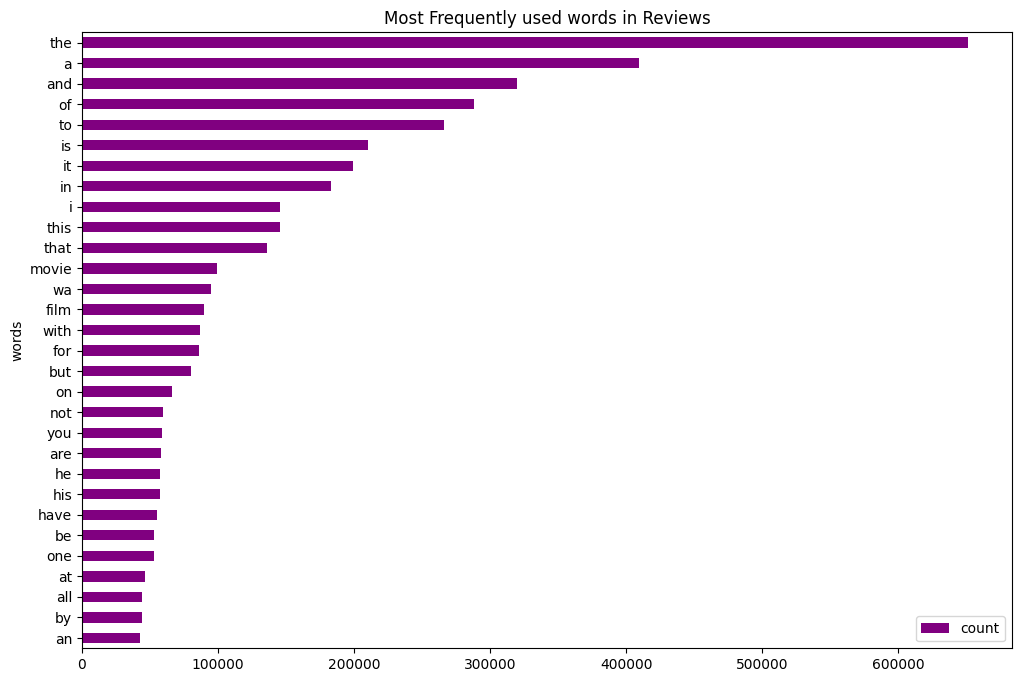

In [ ]:
import itertools
import collections
import pandas as pd
import matplotlib.pyplot as plt
lemmatized_tokens = list(imdb_reviews["lemmatized_tokens"])
token_list = list(itertools.chain(*lemmatized_tokens))
counts_no = collections.Counter(token_list)
clean_reviews = pd.DataFrame(counts_no.most_common(30),
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(12, 8))
clean_reviews.sort_values(by='count').plot.barh(x='words',
                         y='count',
                         ax=ax,
                         color="purple")
ax.set_title("Most Frequently used words in Reviews")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_converter = TfidfVectorizer(max_features=2000)
features = tfidf_converter.fit_transform(imdb_reviews['review']).toarray()

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

target = imdb_reviews['sentiment']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
clf = lgb.LGBMClassifier(
    max_depth=20,
    n_estimators=25,
    min_child_weight=0.0016,
    n_jobs=-1,
    num_leaves=64  # Adjust parameter based on data and model performance
)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

print("Test data Accuracy is :", accuracy_score(y_test , pred))
print(classification_report(y_test, pred))

[LightGBM] [Info] Number of positive: 17465, number of negative: 17535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.998920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398211
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 2000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499000 -> initscore=-0.004000
[LightGBM] [Info] Start training from score -0.004000
Test data Accuracy is : 0.8089333333333333
              precision    recall  f1-score   support

    negative       0.82      0.78      0.80      7465
    positive       0.80      0.83      0.81      7535

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000



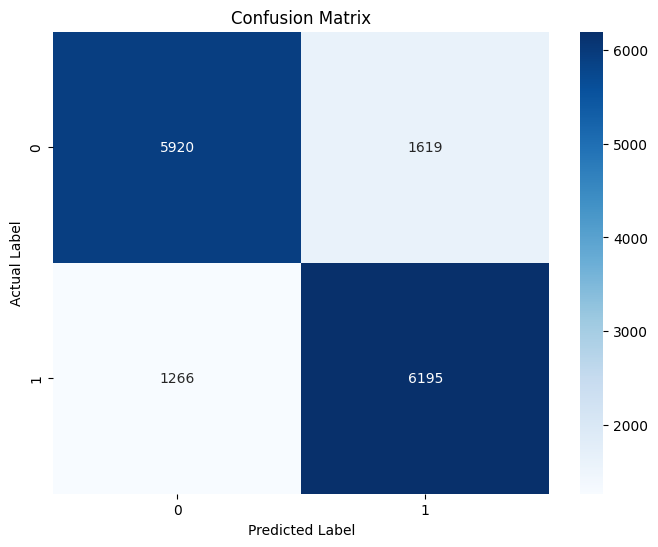

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import numpy as np
mapping = {"positive": 1, "negative": 0}
pred = np.vectorize(mapping.get)(pred)
y_test = np.vectorize(mapping.get)(y_test)
print(y_test)
print(pred)

[1 1 0 ... 0 1 1]
[0 1 0 ... 1 1 1]


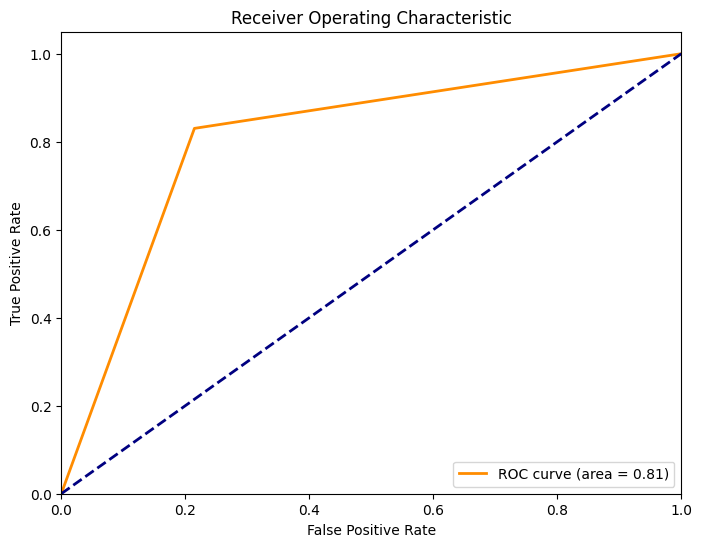

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()